<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/ch03/linear_regression_with_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

- 인터넷주소를 통해 데이터를 가져오기

In [2]:
data_file1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [3]:
data1 = pd.read_csv(data_file1)

In [4]:
data1.iloc[158,28:-7]

2/15/20       28
2/16/20       29
2/17/20       30
2/18/20       31
2/19/20       31
           ...  
3/5/21     92055
3/6/21     92471
3/7/21     92817
3/8/21     93263
3/9/21     93733
Name: 158, Length: 389, dtype: object

- 연결된 컴퓨터의 절대경로(또는 상대경로)를 이용하여 데이터를 가져오기

In [5]:
data_file2 = '/content/drive/MyDrive/tmp/2020_KR_metropolitan_Region_Mobility_Report.csv'

In [6]:
data2 = pd.read_csv(data_file2)

- 같은 기간의 데이터만을 추출하기

In [7]:
x0 = data2.iloc[:,9:]
date = data2['date']
x0.shape

(389, 6)

In [8]:
x0.columns.values

array(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'], dtype=object)

In [9]:
y0 = data1.iloc[158,28:-7].values - data1.iloc[158,27:-8].values
y0.shape


(389,)

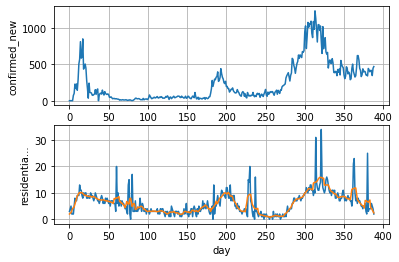

In [10]:
n=5

plt.subplot(2,1,1)
plt.plot(y0)
plt.xlabel('day')
plt.ylabel('confirmed_new')
plt.grid('both')

plt.subplot(2,1,2)
plt.plot(x0.iloc[:,n])
plt.plot(np.convolve(x0.iloc[:,n],np.ones(7)/7,mode='same'))
plt.xlabel('day')
ylbl = x0.columns.values[n]
plt.ylabel(ylbl[:10]+'...')
plt.grid('both')

plt.show()

- 1D filtering (노이즈감소)

In [11]:
for n in range(0,6):
  x0.iloc[:,n] = np.convolve(x0.iloc[:,n],np.ones(7)/7,mode='same')

- PyTorch Tensor로 변환

In [12]:
labels = torch.tensor(np.array(y0,dtype=np.float32))
labels.reshape((-1,1))
labels.shape

torch.Size([389])

In [14]:
features = torch.tensor(np.array(x0,dtype=np.float32))
features.shape

torch.Size([389, 6])

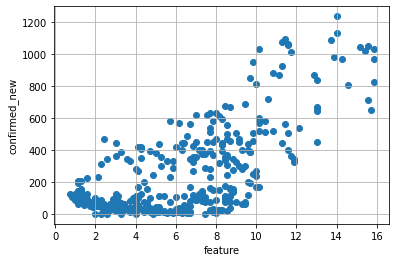

In [15]:
n = 5
plt.scatter(features[:,n],labels)
plt.xlabel('feature')
plt.ylabel('confirmed_new')
plt.grid('both')

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 32
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-6.2857e+00,  1.0429e+01,  5.7714e+01, -4.5714e+00, -3.1429e+00,
          3.4286e+00],
        [-6.8571e+00,  1.1429e+01,  6.7857e+01, -7.0000e+00, -1.0857e+01,
          5.4286e+00],
        [-6.4286e+00,  6.7143e+00,  4.4000e+01, -5.8571e+00, -3.0000e+00,
          2.4286e+00],
        [-3.3286e+01, -2.4286e+00, -1.7571e+01, -2.1857e+01, -1.8286e+01,
          1.3000e+01],
        [-1.8143e+01,  4.2857e+00,  5.9714e+01, -1.3857e+01, -7.8571e+00,
          7.0000e+00],
        [-9.0000e+00,  6.5714e+00,  3.9000e+01, -6.1429e+00, -2.8571e+00,
          4.0000e+00],
        [-8.0000e+00,  7.8571e+00,  4.9429e+01, -5.7143e+00, -3.2857e+00,
          3.8571e+00],
        [-3.2286e+01,  3.1429e+00,  3.3000e+01, -2.3571e+01, -1.8286e+01,
          9.5714e+00],
        [-6.2857e+00,  4.4286e+00,  3.4286e+01, -9.7143e+00, -8.2857e+00,
          3.1429e+00],
        [-2.3143e+01, -4.2857e-01,  2.0143e+01, -1.9429e+01, -7.2857e+00,
          8.4286e+00],
        [-6.4286e+00,  1.2857e

In [18]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

In [19]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [20]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

- Parameter Initialization




In [21]:
w = torch.normal(0, 0.01, size=(6,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

- Hyperparameters

In [22]:
lr = 0.0005
num_epochs = 8000
net = linreg
loss = squared_loss

- Training

In [23]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)

        if epoch%1000==0:
          print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 15770.312500
epoch 1001, loss 10294.830078
epoch 2001, loss 10538.718750
epoch 3001, loss 10589.447266
epoch 4001, loss 10332.072266
epoch 5001, loss 10150.711914
epoch 6001, loss 10415.927734
epoch 7001, loss 10189.234375


In [24]:
w

tensor([[-7.0558],
        [ 7.5012],
        [-5.3116],
        [19.0316],
        [ 1.2722],
        [66.7804]], requires_grad=True)

In [26]:
x0.columns.values

array(['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'], dtype=object)